# Physical Property Data

Read data from Google Spreadsheet [CBE20255_Physical_Property_Data](https://docs.google.com/spreadsheets/d/1fqSoo-uQKdTtBxe9jvJF-ScqJjoyfQHk4ovtE_bKPSQ/edit#gid=0)

In [440]:
import pandas as pd
from StringIO import StringIO
import requests

url = 'https://docs.google.com/spreadsheet/ccc?key=' \
      + '1fqSoo-uQKdTtBxe9jvJF-ScqJjoyfQHk4ovtE_bKPSQ' \
      + '&output=csv'

Elements = pd.read_csv(StringIO(requests.get(url).content), index_col=1)
Elements.head()

Element  Atomic Number  Atomic Mass
Symbol                                       
Q          Charge              0     0.000000
e        Electron              0     0.000000
H        Hydrogen              1     1.007940
D       Deuterium              1     2.014102
T         Tritium              1     3.016049

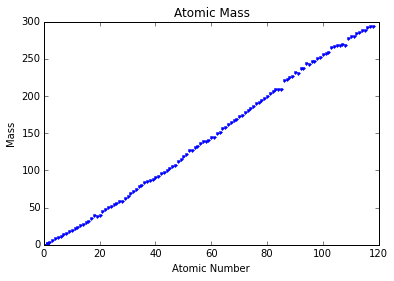

In [437]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(Elements['Atomic Number'],Elements['Atomic Mass'],'.')
plt.title('Atomic Mass')
plt.ylabel('Mass')
plt.xlabel('Atomic Number')

## Parsing Chemical Formula

The standard conventions for writing chemical formulas, such as H<sub>2</sub>O and CH<sub>2</sub>(CH<sub>3</sub>)<sub>6</sub>CH<sub>2</sub>, can be parsed in python and the results used for various calculations.


In [557]:
import re

srex = r"""
     (\([\w\(\)]+\))   # match recursive group within parentheses
    |(A[cglmrstu]|B[aehikr]?|C[adeflmnorsu]?
     |D[bsy]?|E[rsu]|F[elmr]?|G[ade]|H[efgos]?|I[nr]?|Kr?
     |L[airuv]|M[dgnot]|N[abdeiop]?|Os?|P[abdmortu]?|R[abefghnu]
     |S[bcegimnr]?|T[abcehilm]?|U|Uuo|Uup|Uut|V|W|Xe|Yb|Z[nr]?|e)
    |(\d*\.\d+|\d+)    # number of atoms or groups
    |([+-])         # charge group integer charge in format +n
"""

def parsetokens(tokens, dictstack):
    # recursion is finished if there are no more tokens
    if len(tokens) == 0:
        # consolidate the stack of dictionaries
        dsummary = {'Q': 0}
        for d in dictstack:
            for key in d.keys():
                if key in dsummary:
                    dsummary[key] += d[key]
                else:
                    dsummary[key] = d[key]
        return dsummary
    
    # unpack first token
    group,symbol,digits,charge = tokens[0]
    
    # store atomic dictionary for this token on the stack
    if group:
        dictstack.append(parseformula(group[1:-1]))
        
    elif symbol:
        dictstack.append({symbol: 1})
        
    elif digits:
        for key in dictstack[-1].keys():
            dictstack[-1][key] *= float(digits)
            
    elif charge:
        if charge == '+':
            dictstack.append({'Q': 1})
        elif charge == '-':
            dictstack.append({'Q': -1})
            
    # recursively process remaining tokens
    return parsetokens(tokens[1:], dictstack)

def parseformula(str):
    return parsetokens(re.findall(srex, str, re.VERBOSE),[])
            
def chemformula(str):
    return parseformula(str)

def mw(str):
    return sum([n*Elements.ix[key]['Atomic Mass'] for (key,n) in parseformula(str).items()])

def charge(str):
    return parseformula(str)['Q']


In [562]:
test = [\
    'Al(OH)2C18H35O2',\
    'D2O',\
    'C8H18',\
    'C6H5NH(COCH3)',\
    'C20H30O2',\
    'C2H4',\
    'CH(CH3(CH2)18CH3)3',\
    'HNO3',\
    'H+',\
    'Ca+2',\
    'OH-',\
    'H2',\
    'NO3-',\
    'SO4-2',\
    'H2O',\
    'CH4',\
    'CH3(CH2)18(CH3)',\
    'H2SO4',\
    'BaCl2',\
    'NaCl',\
    'Ca(NO3-)2',\
    'C6H5OH']

for t in test:
    print "{0:<20s}| ".format(t),
    print "{0:7.3f}  |".format(mw(t)),
    print "{0:4.1f}  |".format(charge(t)),
    print parseformula(t)

Al(OH)2C18H35O2     |  344.471  |  0.0  | {'Q': 0.0, 'H': 37.0, 'C': 18.0, 'Al': 1, 'O': 4.0}
D2O                 |   20.028  |  0.0  | {'Q': 0, 'D': 2.0, 'O': 1}
C8H18               |  114.231  |  0.0  | {'Q': 0, 'H': 18.0, 'C': 8.0}
C6H5NH(COCH3)       |  135.166  |  0.0  | {'Q': 0, 'H': 9.0, 'C': 8.0, 'O': 1, 'N': 1}
C20H30O2            |  302.457  |  0.0  | {'Q': 0, 'H': 30.0, 'C': 20.0, 'O': 2.0}
C2H4                |   28.054  |  0.0  | {'Q': 0, 'H': 4.0, 'C': 2.0}
CH(CH3(CH2)18CH3)3  |  860.679  |  0.0  | {'Q': 0.0, 'H': 127.0, 'C': 61.0}
HNO3                |   63.013  |  0.0  | {'Q': 0, 'H': 1, 'O': 3.0, 'N': 1}
H+                  |    1.008  |  1.0  | {'Q': 1, 'H': 1}
Ca+2                |   40.078  |  2.0  | {'Q': 2.0, 'Ca': 1}
OH-                 |   17.007  | -1.0  | {'Q': -1, 'H': 1, 'O': 1}
H2                  |    2.016  |  0.0  | {'Q': 0, 'H': 2.0}
NO3-                |   62.005  | -1.0  | {'Q': -1, 'O': 3.0, 'N': 1}
SO4-2               |   96.064  | -2.0  | {'Q': -2.

In [595]:
test = ['C8H18','O2','CO2','H2O']

stoich = {}
for t in test:
    p = parseformula(t)
    for key in p.keys():
        stoich[t,key] = p[key]
    
    

In [596]:
import numpy as np

atoms = sorted(set([a for s,a in stoich.keys()]))
species = sorted(set([s for s,a in stoich.keys()]))

In [597]:
print "{0:<18s}".format(''),
for a in atoms:
    print "{0:>5s}".format(a),
print
for s in species:
    print "{0:<18s}".format(s),
    for a in atoms:
        if (s,a) in stoich:
            print "{0:5.0f}".format(stoich[s,a]),
        else:
            print "{0:5.0f}".format(0),
    print

                       C     H     O     Q
C8H18                  8    18     0     0
CO2                    1     0     2     0
H2O                    0     2     1     0
O2                     0     0     2     0
